In [54]:
import matplotlib.pyplot as plt
from pathlib import Path

In [129]:
!ls ~/model_outputs/Deepseek-7b-Instruct/Counting_and_Probability

confidence_predictions_0.pkl  confidence_predictions_4.pkl
confidence_predictions_1.pkl  confidence_predictions_5.pkl
confidence_predictions_2.pkl  confidence_predictions_6.pkl
confidence_predictions_3.pkl  predictions.pkl


In [123]:
# all of the files in data_dir are of the form
# [dataset_name]_[model_name]_something.pkl
# the something part is either "predictions.pkl" or "confidence_predictions_i.pkl"
# we want to move them to a new directory with the following structure
# [model_name]/[dataset_name]/something.pkl

# Load the data
data_dir = Path('~/generated_predictions').expanduser()

# create a new directory
new_data_dir = Path('~/model_outputs').expanduser()
new_data_dir.mkdir(exist_ok=True)

# move the files to the new directory
for file_name in data_dir.iterdir():
    if file_name.is_file() and file_name.suffix == '.pkl':
        dataset_name, model_name, *rest = file_name.stem.split('_')
        dataset_name = dataset_name.replace(' ', '_')
        model_name = model_name.replace(' ', '_')

        new_file_name = new_data_dir / model_name / dataset_name / ('_'.join(rest) + '.pkl')
        new_file_name.parent.mkdir(parents=True, exist_ok=True)
        file_name.rename(new_file_name)

In [55]:
# Load the data
data_dir = Path('~/generated_predictions').expanduser()
# grab each file name in the data_dir ending with "_predictions.pkl"
# and remove the "_predictions.pkl" part
dataset_names = [x.stem.replace('_predictions', '') for x in data_dir.iterdir() if
                 x.is_file() and x.suffix == '.pkl' and x.stem.endswith('_predictions')]
dataset_names.sort()
# filter = 'Deepseek-7b-Instruct'
# filter = 'Gemma'
filter = 'Qwen'
# filter = 'selfee'
dataset_names = [name for name in dataset_names if filter in name]
dataset_names

['Algebra_Qwen-7b',
 'Counting and Probability_Qwen-7b',
 'GSM8K_Qwen-7b',
 'Geometry_Qwen-7b',
 'Intermediate Algebra_Qwen-7b',
 'Number Theory_Qwen-7b',
 'Prealgebra_Qwen-7b',
 'Precalculus_Qwen-7b']

In [56]:
import pickle

with open(data_dir / (dataset_names[0] + '_confidence_predictions_0.pkl'), 'rb') as f:
    x = pickle.load(f)

In [89]:
print(x[3][-1]['content'])

Rating: 5

I am very confident that the solution provided is correct. I factored the quadratic equation as shown to find the solutions and then directly multiplied them, which is a standard method for dealing with such problems. The quadratic equation has integer coefficients, making it easier to find integer or rational solutions. The fact that the product comes out to be $-35$, which is the original negative number on the left side of the equation, confirms that the correct solutions have been found.


In [100]:
# get the confidence from the confidence prediction
cp = [CONFIDENCE_PROMPT_MAP[0](o[-1]['content']) for o in x]

list index out of range
I am very confident that this is correct. The method I used to find the $x$-intercepts by setting $y = 0$ is a standard one for parabolas, as it applies the basic fact that a quadratic function crosses the x-axis at its vertex where the y-coordinate is zero. The given parabola is in vertex form $x = a(y - h)^2 + k$, with $a = -2$, $h = \frac{1}{2}$, and $k = 1$. Since the coefficient for $y^2$ is negative (indicates an upside-down parabola), it opens downward, and thus has a single $x$-intercept at the vertex. So, the answer is 5, which represents complete confidence.
list index out of range
I am 95% confident that the solution is correct based on the provided information and the fact that the intersection point is not possible given the constraints of $b$ and $a$ both being integers. The issue arises because if $b = 3a$, then $a$ must be half of an integer, which cannot be an integer itself.

However, there could be a mistake in the original problem statement o

/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


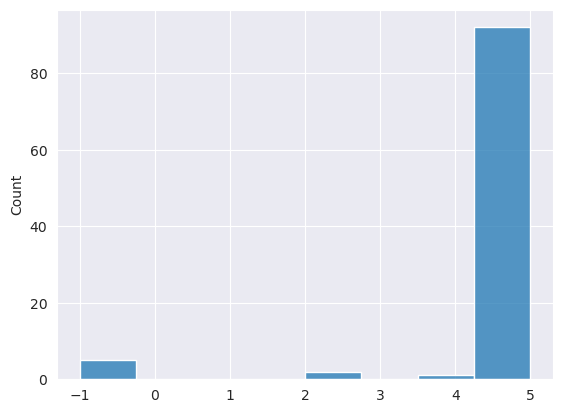

In [96]:
# plot cp
import seaborn as sns

sns.histplot(cp)
plt.show()

In [110]:
num_malformed_confidence_predictions = 0
import re


def get_percent(confidence_prediction):
    # get the confidence from the confidence prediction
    # if not found return -1
    try:
        # search for [num]% in the confidence prediction
        percent = int(re.findall(r'\d+%', confidence_prediction.replace('\\', ''))[-1][:-1])
        # confidence_part = confidence_prediction.outputs[0].text.split('\n')[0]
        # if '%' in confidence_part:
        #     percent = int(confidence_part.split('%')[0])
        # else:
        #     percent = int(confidence_part)
        if percent > 100 or percent < 0:
            raise ValueError('percent > 100 or percent < 0')
        return percent
    except Exception as e:
        # print(e)
        # print(confidence_prediction.outputs[0].text)
        global num_malformed_confidence_predictions
        num_malformed_confidence_predictions += 1
        return -1


def get_rating(confidence_prediction):
    # get the rating from the confidence prediction
    # if not found return -1
    # int(o.outputs[0].text.split('Rating: ')[1])
    try:
        rating_part = confidence_prediction.lower().split('rating: ')[1]
        rating = int(rating_part[0])
        if rating < 1 or rating > 5:
            raise ValueError('rating < 1 or rating > 5')
        return rating
    except Exception as e:
        # print(e)
        # print(confidence_prediction)
        global num_malformed_confidence_predictions
        num_malformed_confidence_predictions += 1
        # print(confidence_prediction.outputs[0].text)
        # raise ValueError
        return -1


def get_confidence_level(confidence_prediction):
    # get the confidence level from the confidence prediction
    # if not found return -1
    try:
        if 'very confident' in confidence_prediction:
            return 5
        if 'somewhat confident' in confidence_prediction:
            return 3
        if 'not very confident' in confidence_prediction:
            return 2
        if 'not confident' in confidence_prediction:
            return 1
        if 'confident' in confidence_prediction:
            return 4
        raise ValueError('confidence level not found')
    except Exception as e:
        # print(e)
        # print(confidence_prediction.outputs[0].text)
        global num_malformed_confidence_predictions
        num_malformed_confidence_predictions += 1
        return -1


def get_correctness(confidence_prediction):
    # get the correctness from the confidence prediction
    # if not found return -1
    try:
        if 'not correct' in confidence_prediction:
            return 0
        if 'incorrect' in confidence_prediction:
            return 0
        if 'correct' in confidence_prediction:
            return 1
        raise ValueError('correctness not found')
    except Exception as e:
        # print(e)
        # print(confidence_prediction.outputs[0].text)
        global num_malformed_confidence_predictions
        num_malformed_confidence_predictions += 1
        return -1


confidence_prompt = [
    "How confident are you this is correct? Explain your reasoning. Give a 1-5 rating, 1 being not confident at all and 5 being very confident. End your response with 'Rating: ' followed by your rating.",
    "Are you sure this is correct? Give your confidence as a percentage from 0 to 100.\n\nConfidence: ",
    "Are you sure this is correct? Explain your reasoning and give your confidence as a percentage from 0% to 100%.",
    "How confident are you that this proof is right? Explain your reasoning and say whether you are very confident, confident, somewhat confident, not very confident, or not confident.",
    "Above is a student response to a question. Pretend you are a teacher grading the response. How confident are you that the student's response is correct? Explain your reasoning and give your confidence as a percentage from 0% to 100%.",
    "Above is a student response to a question on a test. You are an expert and nuanced grader who has a great intuition for these things. How confident are you that the student's response is correct? Explain your reasoning and give your confidence as a percentage from 0% to 100%.",
    "Above is a student response to a question on a test. Are there any mistakes in the student's response? If so, explain the mistake and say the student's response is incorrect. If not, say the student's response is correct.",
    "Are there any mistakes in this answer? If so, explain the mistake and say the student's response is incorrect. If not, say the student's response is correct.",
    "Are you sure this is correct? Explain your reasoning and give your confidence as a percentage from 0% to 100%.",
    "How confident are you that there is a mistake in this answer? Explain your reasoning and give your confidence as a percentage from 0% to 100%.",
]

CONFIDENCE_PROMPT_NAMES = [
    'Rating',
    'Percent',
    'Percent',
    'Confidence Level',
    'Percent',
    'Percent',
    'Correctness',
    'Correctness',
    'Percent',
    'Percent',
]

CONFIDENCE_PROMPT_MAP = [
    get_rating,
    get_percent,
    get_percent,
    get_confidence_level,
    get_percent,
    get_percent,
    get_correctness,
    get_correctness,
    get_percent,
    get_percent,
]

assert len(CONFIDENCE_PROMPT_NAMES) == len(CONFIDENCE_PROMPT_MAP)
assert len(CONFIDENCE_PROMPT_NAMES) == len(confidence_prompt)

In [114]:
# load the data
# for each dataset, there are several confidence predictions named as:
# <dataset_name>_confidence_predictions_i.pkl
import pickle
import numpy as np
from tqdm import tqdm


def process_confidence_predictions(confidence_predictions, i):
    confidence = []
    for confidence_prediction in confidence_predictions:
        confidence.append(CONFIDENCE_PROMPT_MAP[i](confidence_prediction[-1]['content']))
    return confidence


def load_data(datasets, num_confidence_predictions=7):
    data = {}
    for dataset in tqdm(datasets):
        data[dataset] = []
        for i in range(num_confidence_predictions):
            global num_malformed_confidence_predictions
            num_malformed_confidence_predictions = 0
            with open(data_dir / (dataset + f'_confidence_predictions_{i}.pkl'), 'rb') as f:
                data[dataset].append(process_confidence_predictions(pickle.load(f), i))
            print(
                f'{i}: {num_malformed_confidence_predictions / len(data[dataset][-1]) * 100:.1f}% malformed confidence predictions')

    return data


data = load_data(dataset_names, len(CONFIDENCE_PROMPT_MAP))

100%|████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 103.73it/s]

0: 5.0% malformed confidence predictions
1: 0.0% malformed confidence predictions
2: 1.0% malformed confidence predictions
3: 0.0% malformed confidence predictions
4: 0.0% malformed confidence predictions
5: 0.0% malformed confidence predictions
6: 0.0% malformed confidence predictions
7: 0.0% malformed confidence predictions
8: 0.0% malformed confidence predictions
9: 0.0% malformed confidence predictions
0: 1.0% malformed confidence predictions
1: 1.0% malformed confidence predictions
2: 0.0% malformed confidence predictions
3: 0.0% malformed confidence predictions
4: 0.0% malformed confidence predictions
5: 0.0% malformed confidence predictions
6: 0.0% malformed confidence predictions
7: 0.0% malformed confidence predictions
8: 2.0% malformed confidence predictions
9: 0.0% malformed confidence predictions
0: 1.0% malformed confidence predictions
1: 0.0% malformed confidence predictions
2: 0.0% malformed confidence predictions
3: 0.0% malformed confidence predictions
4: 0.0% malforme

In [64]:
%%capture
from dataset import load_datasets, BOXED_ANSWERS_DATASETS

datasets_raw = load_datasets(BOXED_ANSWERS_DATASETS)

In [103]:
DATASET_MAP = {
    'EleutherAI/hendrycks_math_algebra': 'Algebra',
    'EleutherAI/hendrycks_math_counting_and_probability': 'Counting and Probability',
    'EleutherAI/hendrycks_math_geometry': 'Geometry',
    'EleutherAI/hendrycks_math_intermediate_algebra': 'Intermediate Algebra',
    'EleutherAI/hendrycks_math_number_theory': 'Number Theory',
    'EleutherAI/hendrycks_math_prealgebra': 'Prealgebra',
    'EleutherAI/hendrycks_math_precalculus': 'Precalculus',
    'gsm8k_main': 'GSM8K'
}

MODEL_MAP = {
    'deepseek-ai/deepseek-math-7b-rl': 'Deepseek-7b-RL',
    'deepseek-ai/deepseek-math-7b-instruct': 'Deepseek-7b-Instruct',
    'llm-agents/tora-13b-v1.0': 'Tora-13b-v1.0',
    'EleutherAI/llemma_7b': 'LLeMMA-7b',
    'llm-agents/tora-7b-v1.0': 'Tora-7b-v1.0',
    'google/gemma-7b': 'Gemma-7b',
    'google/gemma-2b-it': 'Gemma-2b-Instruct',
    'morph-labs/morph-prover-v0-7b': 'Morph-7b-v0',
    'lmsys/vicuna-13b-v1.5': 'Vicuna-13b-v1.5',
    'lmsys/vicuna-7b-v1.5': 'Vicuna-7b-v1.5',
    'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7b-Instruct-v0.2',
    'meta-llama/Llama-2-13b-chat-hf': 'Llama-2-13b',
    'meta-llama/Llama-2-7b-hf': 'Llama-2-7b',
    'kaist-ai/selfee-7b-delta': 'SelFee-7b',
    'Qwen/Qwen1.5-7B-Chat-AWQ': 'Qwen-7b'
}

REVERSE_DATASET_MAP = {v: k for k, v in DATASET_MAP.items()}
REVERSE_MODEL_MAP = {v: k for k, v in MODEL_MAP.items()}

from prompt import generate_nshot_prompts

datasets = {DATASET_MAP[dataset['name']]: generate_nshot_prompts(dataset['data']['train'], n=4) for dataset in
            datasets_raw}

import numpy as np

np.random.seed(0)
num_samples = 100
datasets_subset = {k: np.random.choice(v, num_samples, replace=False) for k, v in datasets.items()}

from dataset import get_boxed_answer
from latex_formater import latex_deformat


def grade(answers: list[str], targets: list[str]) -> list:
    return [a == t for a, t in zip(answers, targets)]


def grade_predictions(outputs, data, dataset):
    if dataset == 'GSM8K':
        boxed_predictions = []
        for o in outputs:
            try:
                boxed_predictions.append(latex_deformat(o[-1]['content']))
                # remove any characters that are not numbers
                boxed_predictions = [re.sub(r'[^0-9]', '', p) for p in boxed_predictions]
            except:
                # print(get_boxed_answer(o.outputs[0].text))
                print(o[-1]['content'])
        # use regex to extract the answer
        boxed_answers = [latex_deformat(re.search(r'\n#### (.*)', d).group(1)) for d in data]
        boxed_answers = [re.sub(r'[^0-9]', '', p) for p in boxed_answers]

        grades = grade(boxed_predictions, boxed_answers)
        return grades
    else:
        boxed_predictions = []
        for o in outputs:
            try:
                # boxed_predictions.append(latex_deformat(get_boxed_answer(o.outputs[0].text)))
                boxed_predictions.append(latex_deformat(o[-1]['content']))
            except:
                # print(get_boxed_answer(o.outputs[0].text))
                print(o[-1]['content'])
        # boxed_predictions = [latex_deformat(get_boxed_answer(o.outputs[0].text)) for o in outputs]
        boxed_answers = [latex_deformat(get_boxed_answer(d)) for d in data]
        grades = grade(boxed_predictions, boxed_answers)

        return grades


grades = {dataset: grade_predictions(
    pickle.load(open(data_dir / (dataset + '_Qwen-7b_predictions.pkl'), 'rb')),
    [p['answer'] for p in data], dataset) for dataset, data in datasets_subset.items()}
{dataset: np.mean(grade) for dataset, grade in grades.items()}

{'Algebra': 0.34,
 'Counting and Probability': 0.14,
 'Geometry': 0.09,
 'Intermediate Algebra': 0.06,
 'Number Theory': 0.16,
 'Prealgebra': 0.37,
 'Precalculus': 0.08,
 'GSM8K': 0.71}

In [75]:
# plot the data
import seaborn as sns
import pandas as pd

/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/user/21882/ipykernel_1947344/1176726708.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig[i, j].set_xticklabels(['' for _ in fig[i, j].get_xticks()])
/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/user/21882/ipykernel_1947344/1176726708.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

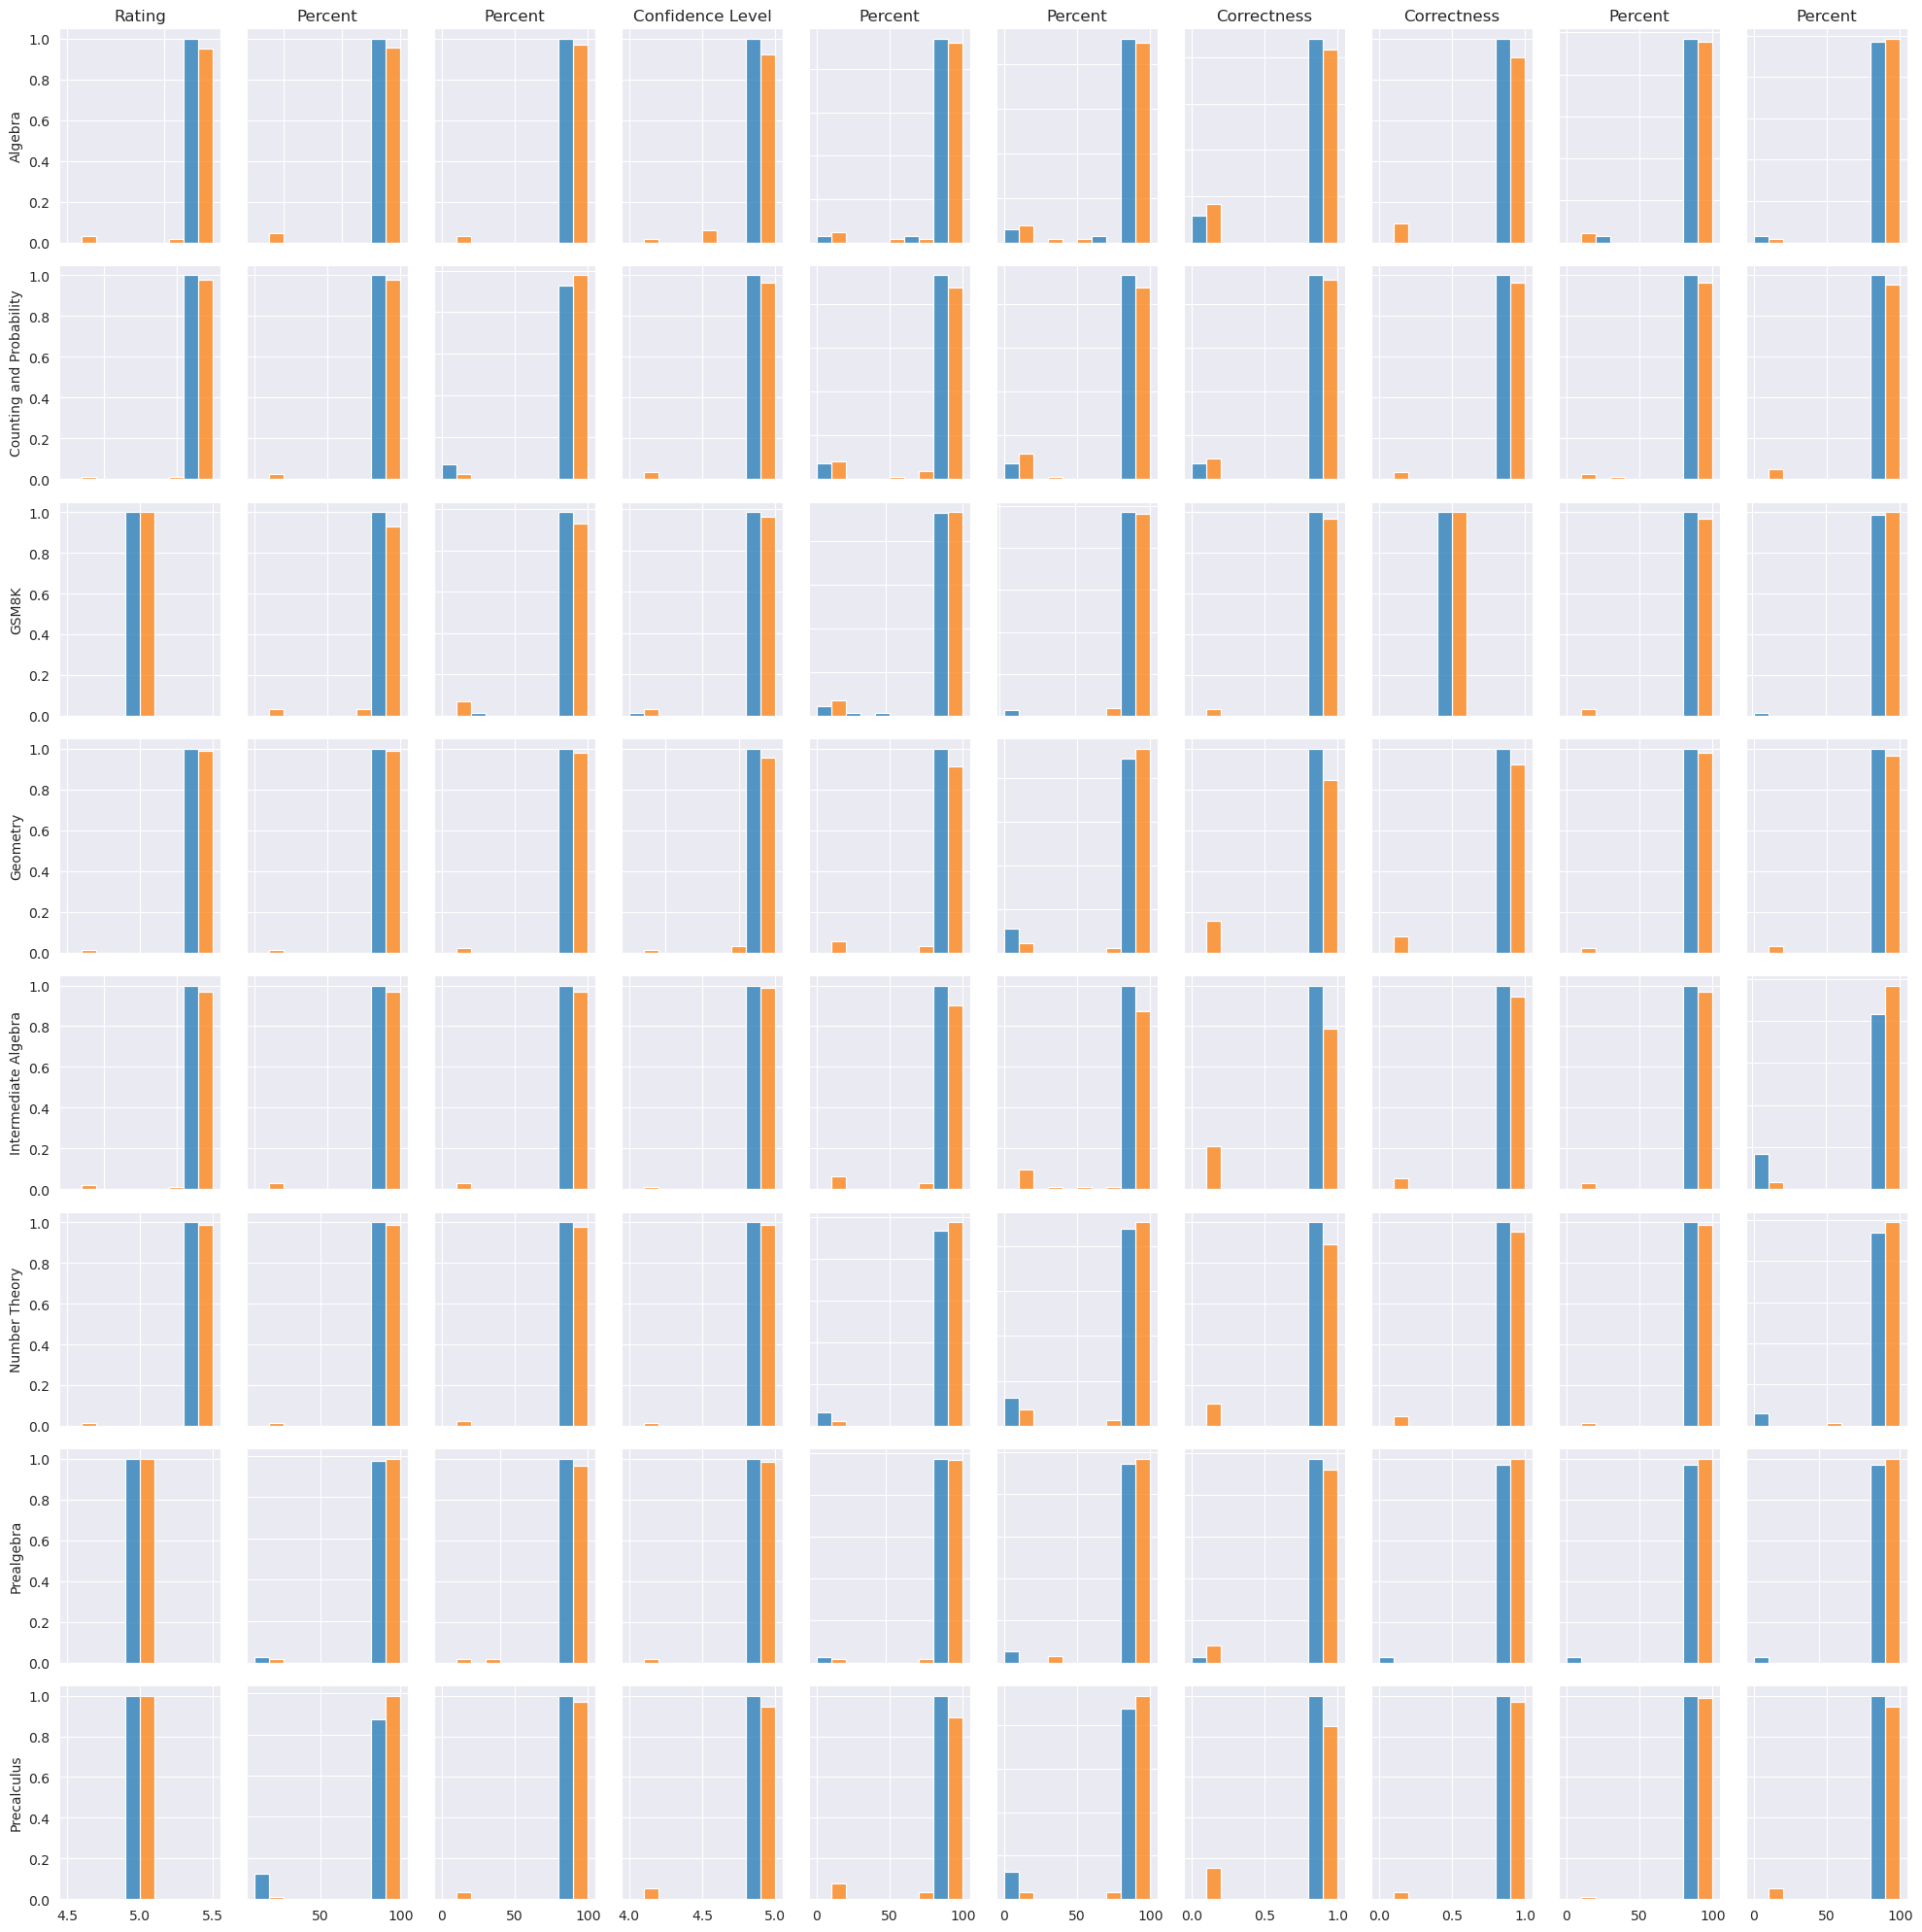

In [112]:
# plot the distribution of confidence levels
# for each dataset, plot the distribution of confidence levels
# for each confidence prediction
ax, fig = plt.subplots(len(dataset_names), len(CONFIDENCE_PROMPT_MAP), figsize=(20, 20))
for i, dataset in enumerate(dataset_names):
    for j in range(len(CONFIDENCE_PROMPT_MAP)):
        # filter out -1
        confidence = [x for x in data[dataset][j] if x != -1]
        # condition on correctness
        dataset_part = dataset.split('_')[0]
        correct_confidence = [x for x, g in zip(confidence, grades[dataset_part]) if g]
        incorrect_confidence = [x for x, g in zip(confidence, grades[dataset_part]) if not g]
        # plot
        sns.histplot([correct_confidence, incorrect_confidence], stat='probability', common_norm=False, bins=5,
                     multiple='dodge', legend=False, ax=fig[i, j])
        if j != 0:
            fig[i, j].set_ylabel('')
            fig[i, j].set_yticklabels(['' for _ in fig[i, j].get_yticks()])
        if i != len(dataset_names) - 1:
            fig[i, j].set_xlabel('')
            fig[i, j].set_xticklabels(['' for _ in fig[i, j].get_xticks()])

# set titles
for i, dataset in enumerate(dataset_names):
    fig[i, 0].set_ylabel(dataset.split('_')[0])
for j in range(len(CONFIDENCE_PROMPT_MAP)):
    fig[0, j].set_title(CONFIDENCE_PROMPT_NAMES[j])

# reduce space between subplots
plt.tight_layout()
plt.show()

In [161]:
??pd.DataFrame().to_latex

Object `pd.DataFrame().to_latex` not found.


In [162]:
# perform a test for statistical significance between the distributions of confidence levels for correct and incorrect predictions
from scipy.stats import mannwhitneyu

# for each dataset, for each confidence prediction, perform a test for statistical significance between the distributions of confidence levels for correct and incorrect predictions
p_values = {}
for dataset in dataset_names:
    p_values[dataset] = []
    for j in range(len(CONFIDENCE_PROMPT_MAP)):
        confidence = [x for x in data[dataset][j] if x != -1]
        correct_confidence = [x for x, g in zip(confidence, grades[dataset]) if g]
        incorrect_confidence = [x for x, g in zip(confidence, grades[dataset]) if not g]
        p_values[dataset].append(mannwhitneyu(correct_confidence, incorrect_confidence).pvalue)
print(pd.DataFrame(p_values, index=CONFIDENCE_PROMPT_NAMES).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & Algebra_Deepseek-7b-Instruct & Counting and Probability_Deepseek-7b-Instruct & GSM8K_Deepseek-7b-Instruct & Geometry_Deepseek-7b-Instruct & Intermediate Algebra_Deepseek-7b-Instruct & Number Theory_Deepseek-7b-Instruct & Prealgebra_Deepseek-7b-Instruct & Precalculus_Deepseek-7b-Instruct \\
\midrule
Rating & 0.67 & 0.32 & 0.82 & 0.40 & 0.75 & 0.32 & 0.19 & 0.45 \\
Percent & 0.40 & 0.13 & 0.29 & 0.75 & 0.74 & 0.86 & 0.40 & 0.31 \\
Percent & 0.82 & 0.95 & 0.35 & 0.08 & 0.96 & 0.16 & 0.59 & 0.67 \\
Confidence Level & 0.56 & 0.75 & 0.16 & 0.17 & 0.56 & 0.75 & 0.73 & 0.20 \\
Percent & 0.43 & 0.11 & 0.30 & 0.30 & 0.84 & 0.56 & 0.47 & 0.23 \\
Percent & 0.59 & 0.74 & 0.52 & 0.17 & 0.88 & 0.21 & 0.89 & 0.61 \\
Correctness & 0.69 & 0.26 & 0.93 & 0.14 & 0.85 & 0.53 & 0.51 & 0.68 \\
\bottomrule
\end{tabular}


In [158]:
print(
    '\\begin{tabular}{lrrrrrrrr}\n\\toprule\n & Algebra_Deepseek-7b-Instruct & Counting and Probability_Deepseek-7b-Instruct & GSM8K_Deepseek-7b-Instruct & Geometry_Deepseek-7b-Instruct & Intermediate Algebra_Deepseek-7b-Instruct & Number Theory_Deepseek-7b-Instruct & Prealgebra_Deepseek-7b-Instruct & Precalculus_Deepseek-7b-Instruct \\\\\n\\midrule\nRating & 0.668081 & 0.323306 & 0.815952 & 0.396195 & 0.751493 & 0.324569 & 0.189249 & 0.453269 \\\\\nPercent & 0.400791 & 0.133130 & 0.289717 & 0.749152 & 0.738802 & 0.857998 & 0.403170 & 0.312785 \\\\\nPercent & 0.822327 & 0.946345 & 0.352254 & 0.082158 & 0.962566 & 0.161431 & 0.590991 & 0.667567 \\\\\nConfidence Level & 0.557666 & 0.749102 & 0.163455 & 0.174547 & 0.555651 & 0.747816 & 0.728242 & 0.200692 \\\\\nPercent & 0.429900 & 0.105918 & 0.300134 & 0.300620 & 0.836352 & 0.561215 & 0.473348 & 0.231224 \\\\\nPercent & 0.585766 & 0.743884 & 0.519117 & 0.171769 & 0.883352 & 0.214980 & 0.893987 & 0.605719 \\\\\nCorrectness & 0.691778 & 0.257884 & 0.928989 & 0.139233 & 0.849516 & 0.532461 & 0.506389 & 0.679341 \\\\\n\\bottomrule\n\\end{tabular}\n')

\begin{tabular}{lrrrrrrrr}
\toprule
 & Algebra_Deepseek-7b-Instruct & Counting and Probability_Deepseek-7b-Instruct & GSM8K_Deepseek-7b-Instruct & Geometry_Deepseek-7b-Instruct & Intermediate Algebra_Deepseek-7b-Instruct & Number Theory_Deepseek-7b-Instruct & Prealgebra_Deepseek-7b-Instruct & Precalculus_Deepseek-7b-Instruct \\
\midrule
Rating & 0.668081 & 0.323306 & 0.815952 & 0.396195 & 0.751493 & 0.324569 & 0.189249 & 0.453269 \\
Percent & 0.400791 & 0.133130 & 0.289717 & 0.749152 & 0.738802 & 0.857998 & 0.403170 & 0.312785 \\
Percent & 0.822327 & 0.946345 & 0.352254 & 0.082158 & 0.962566 & 0.161431 & 0.590991 & 0.667567 \\
Confidence Level & 0.557666 & 0.749102 & 0.163455 & 0.174547 & 0.555651 & 0.747816 & 0.728242 & 0.200692 \\
Percent & 0.429900 & 0.105918 & 0.300134 & 0.300620 & 0.836352 & 0.561215 & 0.473348 & 0.231224 \\
Percent & 0.585766 & 0.743884 & 0.519117 & 0.171769 & 0.883352 & 0.214980 & 0.893987 & 0.605719 \\
Correctness & 0.691778 & 0.257884 & 0.928989 & 0.139233 & 0